### **1. Introduction & Learning Objectives**

In this notebook, we take our next major conceptual leap — from **Autoencoders (AEs)** to **Variational Autoencoders (VAEs)**.  
So far, we have explored how autoencoders learn to *reconstruct* what they see, compressing information into a latent representation that captures key features of the data.  
We used these ideas for **anomaly detection** and **denoising**, showing how reconstruction quality reveals how well the model “understands” an input.

Now, we move from **deterministic reconstruction** to **probabilistic generation**.  
VAEs extend autoencoders by introducing a **probabilistic latent space**, allowing us to not only rebuild existing data but also **generate entirely new, realistic samples**.  
This makes VAEs one of the most foundational generative models in deep learning.

**Recap: What We Learned So Far**
- **Autoencoders (AEs)** compress data through an encoder and reconstruct it through a decoder.  
- They are powerful tools for **unsupervised representation learning**.  
- We used AEs to:
  - Detect anomalies via reconstruction error.  
  - Denoise corrupted inputs and recover structure.  
- However, AEs lack a **structured latent space** — making them poor generators of **new data**.

**The New Question**

How can we make the latent space *continuous, structured,* and *sampleable*, so that we can **generate new faces** instead of merely reconstructing known ones?

**Enter the Variational Autoencoder (VAE)**

VAEs solve this by treating the latent space as a **probability distribution**, not a fixed vector.  
Instead of encoding an input into a single point, we learn a **mean (μ)** and **variance (σ²)** that define a Gaussian distribution for each input.  
We can then *sample* from this distribution to produce diverse outputs.

> In essence, the VAE learns how to imagine — creating realistic new samples by understanding the distribution of the data itself.

**Learning Objectives**

By the end of this notebook, we will be able to:
1. **Understand the conceptual shift** from standard Autoencoders to Variational Autoencoders.  
2. **Implement a basic VAE** architecture in PyTorch using FER2013 face data.  
3. **Generate new synthetic faces** by sampling from the learned latent space.  
4. **Visualize and compare** AE vs. VAE outputs to understand the benefits of probabilistic modeling.

This marks our entry into the realm of **generative deep learning** — where models don’t just learn from data, they *create* it.

---

### **2. Conceptual Bridge: From AE to VAE**

Before diving into code, let’s take a moment to understand **why** we need Variational Autoencoders (VAEs) — and what conceptual gap they fill beyond standard Autoencoders (AEs).

**What Autoencoders Can and Cannot Do**

In a **standard Autoencoder**, we compress an input image into a latent vector `z` using an **encoder**, and then reconstruct it using a **decoder**:

$$
x \xrightarrow[\text{encode}]{f_\theta} z \xrightarrow[\text{decode}]{g_\phi} \hat{x}
$$

The encoder learns a deterministic function:

$$
z = f_\theta(x)
$$

Here:
- `x` is the input (e.g., a face image),
- `z` is the encoded latent vector,
- `θ` and `φ` are the encoder and decoder parameters.

This structure works beautifully for **reconstruction**, **denoising**, or **feature extraction**, but it has a critical limitation:

> 🧩 **Limitation:** The latent space learned by an AE is **unstructured** and **discontinuous**.  
> There’s no guarantee that points between known samples in latent space will decode to valid faces.

If we pick a random point `z` and feed it to the decoder, the result is often **nonsensical noise** — because the AE never learned what the *latent distribution* should look like.

**The Motivation for a Probabilistic Latent Space**

To generate realistic new samples, we want our latent space to be:
- **Continuous** – small changes in `z` lead to smooth changes in output.
- **Structured** – nearby points correspond to similar inputs.
- **Sampleable** – we can draw new `z` values and still get valid outputs.

This is where **Variational Autoencoders (VAEs)** come in.  
Instead of mapping each input to a *single latent vector*, a VAE maps it to a **distribution** in the latent space.

**From Deterministic Codes to Distributions**

| Model | Latent Representation | Key Property |
|--------|------------------------|---------------|
| **Autoencoder (AE)** | $ z = f_\theta(x) $ | Single point (deterministic) |
| **Variational Autoencoder (VAE)** | $ z \sim \mathcal{N}(\mu, \sigma^2) $ | Distribution (probabilistic) |

In a VAE:
- The **encoder** outputs two vectors — a mean $ \mu $ and a log-variance $ \log\sigma^2 $.  
- Together, they define a **Gaussian distribution** for each input image:
  $$
  q_\theta(z|x) = \mathcal{N}(z; \mu(x), \sigma^2(x))
  $$
- The **decoder** then reconstructs from a **sample** of this distribution:
  $$
  \hat{x} = g_\phi(z)
  $$

This introduces controlled randomness that helps the model learn **smooth, continuous latent spaces**.

**Intuitive Analogy**

Think of each input image as a *cloud* in the latent space, not a single dot.  
Each cloud’s center (mean) represents the core features of the face, while its spread (variance) captures uncertainty or variability (like different lighting or small expressions).

When we sample from these clouds, we can smoothly interpolate between known data points — generating new, plausible faces.

**Schematic Overview**

Below is a conceptual diagram (to be visualized in the notebook):

**| Autoencoder (AE) |** ---------------------|--------------------**| Variational Autoencoder (VAE) |**
```text
         x                                                  x
         ↓                                                  ↓
   ┌────────────┐                                    ┌────────────┐
   │  Encoder   │                                    │  Encoder   │
   └────────────┘                                    └────────────┘
         ↓                                                  ↓
      z = f(x)                                          μ(x), σ(x)
                                                            ↓
                                                   z ~ N(μ, σ²)   ← Sample
                                                            ↓
                                                      ┌────────────┐
                                                      │  Decoder   │
                                                      └────────────┘
                                                            ↓
                                                            x̂

```

**Why This Matters**

By making the latent representation *probabilistic*:
- We encourage **smooth transitions** in latent space.
- We can **sample new z values** from $ \mathcal{N}(0, I) $ to create novel faces.
- We gain a model that not only reconstructs but **generates**.

In short:
> The VAE transforms the Autoencoder from a *compressor* into a *creator.*

Next, we’ll make this concept practical by introducing the **reparameterization trick**, which allows us to sample from these latent distributions while keeping the model differentiable for backpropagation.

---


### **3. The Reparameterization Trick**

Now that we understand that the **VAE encodes each input into a distribution**, the next question is:  
How can we **sample** from that distribution *while keeping the model differentiable*?

**The Challenge: Non-Differentiable Sampling**

In a Variational Autoencoder, the encoder predicts two quantities for each input image:
$$
\mu(x), \; \log\sigma^2(x)
$$
Together, they define a Gaussian latent distribution:
$$
z \sim \mathcal{N}(\mu, \sigma^2)
$$

However, **sampling directly** from this distribution breaks the computational graph — the randomness makes it impossible for gradients to flow back through the sampling step.  
That means the model can’t learn effectively via backpropagation.

> 🧩 **Problem:** Sampling is stochastic and non-differentiable.  
> We need a way to “sample” that still allows gradients to pass through the encoder.

**The Reparameterization Trick**

To solve this, we **separate the randomness** from the deterministic parameters (μ, σ).  
We introduce a random variable $ \epsilon $ drawn from a standard normal distribution:
$$
\epsilon \sim \mathcal{N}(0, I)
$$
and compute:
$$
z = \mu + \sigma \odot \epsilon
$$

This equation expresses the sample `z` as a **deterministic transformation** of μ, σ, and a random ε.  
Because ε is the *only* source of randomness, gradients can still flow through μ and σ.

> 💡 The model doesn’t directly sample from the distribution —  
> it *constructs* a sample by shifting and scaling a noise vector.

**Visual Intuition**

Think of this operation as:
> “Take a random standard-normal vector (ε),  
> stretch it by σ, shift it by μ — and you now have a sample z.”

This way:
- The **noise** provides stochasticity.  
- The **parameters (μ, σ)** remain differentiable.  

Hence, we get **stochastic sampling + gradient flow** — the best of both worlds!

**Code Demo: Sampling with Reparameterization**

Let’s visualize this process with a small PyTorch snippet.

In [108]:
import torch

# Suppose the encoder produced these:
mu = torch.tensor([0.0, 1.0, -1.0])
log_var = torch.tensor([-1.0, 0.0, 1.0])  # log(σ²)
sigma = torch.exp(0.5 * log_var)

# Sample epsilon ~ N(0, I)
epsilon = torch.randn_like(sigma)

# Reparameterization
z = mu + sigma * epsilon

print("mu      :", mu)
print("sigma   :", sigma)
print("epsilon :", epsilon)
print("z (sampled latent vector):", z)

mu      : tensor([ 0.,  1., -1.])
sigma   : tensor([0.6065, 1.0000, 1.6487])
epsilon : tensor([ 1.7001,  0.4751, -0.6995])
z (sampled latent vector): tensor([ 1.0312,  1.4751, -2.1533])


Expected behavior:

- Each time we run the code, epsilon (and hence z) changes — but mu and sigma remain differentiable parameters.

**Summary**

| Concept                 | Formula                             | Role                       |
| ----------------------- | ----------------------------------- | -------------------------- |
| Random noise            | $ \epsilon \sim \mathcal{N}(0, I) $ | Provides stochasticity     |
| Deterministic transform | $ z = \mu + \sigma \odot \epsilon $ | Enables gradient flow      |
| Key benefit             | Differentiable sampling             | Allows end-to-end training |


>✨ The reparameterization trick is what makes VAEs trainable — it bridges stochastic sampling and gradient-based optimization.

Next, we’ll define the VAE loss function, which combines reconstruction accuracy with latent-space regularization (via KL divergence).

---

### **4. VAE Architecture Definition**

We now move from concept to implementation — defining a **Variational Autoencoder (VAE)** architecture in PyTorch.  
Structurally, the VAE resembles a standard autoencoder, but with an important twist:  
> The **encoder** produces *two* outputs — the mean (μ) and log-variance (logσ²) — to define a Gaussian latent distribution.

**Architecture Overview**

Let’s recall the main flow:

$$
x \xrightarrow[\text{encode}]{f_\theta} (\mu, \log\sigma^2)
\quad \xrightarrow[\text{sample via reparam}]{z = \mu + \sigma \odot \epsilon}
\quad \xrightarrow[\text{decode}]{g_\phi} \hat{x}
$$

- **Encoder:** Maps input image → mean and log-variance vectors.  
- **Reparameterization:** Samples `z` in a differentiable way.  
- **Decoder:** Reconstructs the image from latent vector `z`.  

The **output** of the decoder uses a **Sigmoid activation** since pixel intensities lie in [0, 1].

**Network Dimensions**

| Component | Layer Structure | Description |
|------------|----------------|--------------|
| **Encoder** | 2304 → 512 → 128 → (μ, logσ²) | Compress input and estimate latent distribution |
| **Latent space** | 128 | Sampled from Gaussian via reparameterization |
| **Decoder** | 128 → 512 → 2304 → Sigmoid | Reconstruct image from latent sample |

Each face image is 48 × 48 grayscale → flattened into a **2,304-dimensional vector**.

**Implementation in PyTorch**


In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=48*48, hidden_dim1=512, hidden_dim2=128, latent_dim=32):
        super(VAE, self).__init__()
        
        # ----- Encoder -----
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)       # Mean vector μ
        self.fc_logvar = nn.Linear(hidden_dim2, latent_dim)   # Log-variance logσ²
        
        # ----- Decoder -----
        self.fc3 = nn.Linear(latent_dim, hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc5 = nn.Linear(hidden_dim1, input_dim)
        
    def encode(self, x):
        """Encode input into mean and log-variance."""
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Apply the reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z
    
    def decode(self, z):
        """Decode latent vector back to image."""
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        x_recon = torch.sigmoid(self.fc5(h))  # constrain to [0,1]
        return x_recon
    
    def forward(self, x):
        """Full forward pass: encode → reparam → decode."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

**Key Points to Emphasize**

- The encoder produces two outputs instead of one (μ and logσ²).
- The reparameterization step introduces stochasticity but remains differentiable.
- The decoder reconstructs images as before, using Sigmoid to keep pixel values valid.
- The latent dimension (latent_dim) is typically small (e.g., 16–64) to encourage compression.

**Quick Sanity Check**

In [110]:
model = VAE(latent_dim = 64) # default is 32
x_dummy = torch.randn(4, 48*48)  # batch of 4 random faces
x_recon, mu, logvar = model(x_dummy)

print("Input shape :", x_dummy.shape)
print("Reconstructed shape:", x_recon.shape)
print("Latent mean shape  :", mu.shape)
print("Latent logvar shape:", logvar.shape)

Input shape : torch.Size([4, 2304])
Reconstructed shape: torch.Size([4, 2304])
Latent mean shape  : torch.Size([4, 64])
Latent logvar shape: torch.Size([4, 64])


**Conceptual Note**

This architecture looks like a regular AE — but conceptually it’s different:

| Aspect                | Autoencoder                  | Variational Autoencoder                 |
| --------------------- | ---------------------------- | --------------------------------------- |
| Latent representation | Deterministic vector         | Probabilistic (mean + variance)         |
| Sampling              | None                         | Differentiable random sampling          |
| Objective             | Minimize reconstruction loss | Minimize reconstruction + KL divergence |
| Capability            | Reconstruction               | Reconstruction + Generation             |


> In essence, the VAE adds a probabilistic brain to the autoencoder — enabling it not only to remember what it has seen, but also to imagine new examples.

Next, we’ll define the VAE loss function, which balances reconstruction quality with latent space regularization through the KL divergence term.

---

### **5. VAE Loss Function**

Our Variational Autoencoder is trained with a **composite loss** that balances two goals:
- Reconstruct each input image faithfully.
- Shape the latent space into a smooth, continuous distribution that we can sample from.

Formally, we minimize
$$
L = L_\text{recon} + L_\text{KL}
$$

**Reconstruction Loss (Fidelity)**
The reconstruction term measures how close the output $\hat{x}$ is to the input $x$.

- **MSE** (mean squared error), suitable for grayscale images in \[0, 1\]:
$$
L_\text{recon}^{\text{MSE}} = \frac{1}{N}\sum_{i=1}^{N}\frac{1}{HW}\sum_{p}(x_{i,p}-\hat{x}_{i,p})^2
$$

- **BCE** (binary cross-entropy), also common for \[0, 1\] pixel intensities with a Sigmoid output:
$$
L_\text{recon}^{\text{BCE}} = -\frac{1}{N}\sum_{i=1}^{N}\frac{1}{HW}\sum_{p}\big[x_{i,p}\log \hat{x}_{i,p} + (1-x_{i,p})\log(1-\hat{x}_{i,p})\big]
$$

Either choice encourages faithful reconstructions. For our 48×48 grayscale faces, **MSE** is a simple, robust default.

**KL Divergence (Latent Regularization)**
The encoder outputs $(\mu, \log\sigma^2)$ for each input, defining a Gaussian in latent space.  
To make the latent space **smooth and sampleable**, we regularize it toward the standard normal $\mathcal{N}(0, I)$ using the KL divergence:
$$
L_\text{KL} = -\frac{1}{2} \sum \big( 1 + \log\sigma^2 - \mu^2 - \sigma^2 \big)
$$

**Intuition:**
- The **KL term** keeps the latent distributions close to a simple prior, encouraging **continuity** and **coverage** of latent space.
- This prevents “holes” where random samples would decode to nonsense, which in turn **enables generation** of new, plausible faces.

**Putting It Together**
We combine both terms:
$$
L = L_\text{recon} + L_\text{KL}
$$

Optionally, we can introduce a weighting factor $\beta$ (the **beta-VAE** idea) to control the trade-off between reconstruction fidelity and latent regularization:
$$
L = L_\text{recon} + \beta \, L_\text{KL}
$$

- Larger $\beta$ strengthens latent structure (more disentanglement, potentially blurrier reconstructions).
- Smaller $\beta$ prioritizes reconstruction sharpness (less regularized latent space).

**Code: `vae_loss()` Implementation**

Below is a clean PyTorch implementation. It supports **MSE** or **BCE** reconstruction and averages loss per batch. We will use it in the training loop.

In [111]:
import torch
import torch.nn.functional as F

def vae_loss(x_recon, x, mu, logvar, recon_type="mse", beta=1.0, reduction="mean"):
    """
    x_recon: reconstructed images, shape (N, 2304) or (N, 1, 48, 48) after flattening
    x:       original images, same shape as x_recon
    mu:      latent mean, shape (N, latent_dim)
    logvar:  latent log-variance, shape (N, latent_dim)
    recon_type: "mse" or "bce"
    beta:    weighting factor for KL term (beta-VAE)
    reduction: "mean" or "sum" over batch

    returns: total_loss, recon_loss, kl_loss
    """

    # Ensure flat (N, 2304) for reconstruction computation
    if x_recon.dim() > 2:
        x_recon = x_recon.view(x_recon.size(0), -1)
    if x.dim() > 2:
        x = x.view(x.size(0), -1)

    # Reconstruction term
    if recon_type.lower() == "mse":
        recon_loss = F.mse_loss(x_recon, x, reduction=reduction)
    elif recon_type.lower() == "bce":
        # Avoid log(0); clamp is handled internally by F.binary_cross_entropy
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction=reduction)
    else:
        raise ValueError("recon_type must be 'mse' or 'bce'.")

    # KL divergence term:
    # L_KL = -0.5 * sum(1 + logvar - mu^2 - exp(logvar)) per sample
    # We average over batch by default (reduction == "mean")
    kl_element = 1 + logvar - mu.pow(2) - logvar.exp()
    if reduction == "sum":
        kl_loss = -0.5 * torch.sum(kl_element)
    elif reduction == "mean":
        kl_loss = -0.5 * torch.mean(torch.sum(kl_element, dim=1))
    else:
        raise ValueError("reduction must be 'mean' or 'sum'.")

    total = recon_loss + beta * kl_loss
    return total, recon_loss, kl_loss

**Notes**

- With a Sigmoid decoder output, both MSE and BCE are valid.
- If you remove the Sigmoid and output logits instead, use F.binary_cross_entropy_with_logits for numerical stability (and pass raw logits from the decoder).
- Start with beta = 1.0 and recon_type = "mse". We can experiment later with beta and with BCE to see the quality–regularization trade-offs.

In the next section, we will plug this loss into our training loop, track both terms over epochs, and observe how the VAE learns to reconstruct faces while shaping a generative latent space.

---

### **6. Training the VAE**

In this section, we train our **Variational Autoencoder (VAE)** on the downsampled FER2013 faces.  
We will load the prepared dataset (`fer2013_small.npz`), build **PyTorch DataLoaders**, and run a training loop that tracks both **reconstruction** and **KL** terms in the loss.

> As total loss decreases, we expect two improvements:  
> - **Better reconstructions** (the decoder learns to reproduce faces more faithfully).  
> - **A more structured latent space** (the encoder learns smooth, well-regularized distributions that are easier to sample from).

**Load Data and Build DataLoaders**

We place `fer2013_small.npz` in the same folder as this notebook and load it here.  
We split into train/validation sets (stratified by emotion labels for balance), and create DataLoaders for minibatch training.

In [112]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Load the downsampled dataset prepared earlier
data = np.load("fer2013_small.npz")
X, y = data["X"], data["y"]          # X: (N, 48, 48) in [0,1], y: (N,)

# Train/validation split (stratified to preserve class proportions)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Convert to torch tensors and flatten to vectors of length 2304 for the VAE
def to_tensor_flat(arr):
    t = torch.tensor(arr, dtype=torch.float32)     # (N, 48, 48)
    t = t.view(t.size(0), -1)                      # (N, 2304)
    return t

X_train_t = to_tensor_flat(X_train)
X_val_t   = to_tensor_flat(X_val)

train_ds = TensorDataset(X_train_t)
val_ds   = TensorDataset(X_val_t)

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(val_loader)


(55, 10)

**Initialize the VAE and Optimizer**

We reuse the VAE class from Section 4 and the vae_loss() function from Section 5.

In [113]:
import torch.nn as nn
import torch.optim as optim

# If the VAE class and vae_loss() are not yet in this runtime, rerun the cells from Sections 4–5 first.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example configuration: latent_dim=32 for a compact, sampleable latent space
model = VAE(input_dim=48*48, hidden_dim1=512, hidden_dim2=128, latent_dim=32).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)


**Training Loop, Tracking Recon and KL**

We report total, reconstruction, and KL losses per epoch for both train and validation sets.

In [114]:
from math import inf

EPOCHS = 15
best_val = inf
best_state = None

def run_epoch(model, loader, train=True, recon_type="mse", beta=1.0):
    if train:
        model.train()
    else:
        model.eval()
    total_sum, recon_sum, kl_sum, count = 0.0, 0.0, 0.0, 0

    for (xb,) in loader:
        xb = xb.to(device)                # xb: (N, 2304)
        if train:
            optimizer.zero_grad()

        x_recon, mu, logvar = model(xb)   # x_recon: (N, 2304)
        total, recon, kl = vae_loss(x_recon, xb, mu, logvar,
                                    recon_type=recon_type, beta=beta, reduction="mean")

        if train:
            total.backward()
            optimizer.step()

        bs = xb.size(0)
        total_sum += total.item() * bs
        recon_sum += recon.item() * bs
        kl_sum    += kl.item() * bs
        count     += bs

    return total_sum / count, recon_sum / count, kl_sum / count

In [115]:
history = {"train_total":[], "train_recon":[], "train_kl":[],
           "val_total":[],   "val_recon":[],   "val_kl":[]}

def kl_weight(epoch, E=EPOCHS, start=0.0, end=1.0):
    # linear warm-up; try sigmoid if you prefer
    return start + (end - start) * (epoch-1)/(E-1)

for epoch in range(1, EPOCHS + 1):
    beta = kl_weight(epoch, EPOCHS, start=0.0, end=1.0)  # or end=0.5
    tr_tot, tr_rec, tr_kl = run_epoch(model, train_loader, train=True,  recon_type="bce", beta=beta)
    va_tot, va_rec, va_kl = run_epoch(model, val_loader,   train=False, recon_type="bce", beta=beta)

    history["train_total"].append(tr_tot); history["train_recon"].append(tr_rec); history["train_kl"].append(tr_kl)
    history["val_total"].append(va_tot);   history["val_recon"].append(va_rec);   history["val_kl"].append(va_kl)

    print(f"Epoch {epoch:02d} | "
          f"train total: {tr_tot:.5f} (recon {tr_rec:.5f}, KL {tr_kl:.5f}) | "
          f"val total: {va_tot:.5f} (recon {va_rec:.5f}, KL {va_kl:.5f})")

    if va_tot < best_val:
        best_val = va_tot
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# Restore best validation weights
if best_state is not None:
    model.load_state_dict(best_state)

Epoch 01 | train total: 0.65901 (recon 0.65901, KL 54.50152) | val total: 0.63781 (recon 0.63781, KL 92.00695)
Epoch 02 | train total: 0.90559 (recon 0.70678, KL 2.78327) | val total: 0.68627 (recon 0.68591, KL 0.00501)
Epoch 03 | train total: 0.68677 (recon 0.68618, KL 0.00413) | val total: 0.68592 (recon 0.68553, KL 0.00271)
Epoch 04 | train total: 0.68670 (recon 0.68618, KL 0.00244) | val total: 0.68609 (recon 0.68573, KL 0.00166)
Epoch 05 | train total: 0.68655 (recon 0.68605, KL 0.00176) | val total: 0.68590 (recon 0.68554, KL 0.00125)
Epoch 06 | train total: 0.68646 (recon 0.68610, KL 0.00101) | val total: 0.68603 (recon 0.68575, KL 0.00078)
Epoch 07 | train total: 0.68624 (recon 0.68602, KL 0.00053) | val total: 0.68574 (recon 0.68559, KL 0.00034)
Epoch 08 | train total: 0.68614 (recon 0.68598, KL 0.00032) | val total: 0.68563 (recon 0.68556, KL 0.00014)
Epoch 09 | train total: 0.68620 (recon 0.68602, KL 0.00032) | val total: 0.68564 (recon 0.68559, KL 0.00009)
Epoch 10 | train 

In [116]:
# Save trained VAE
try:
    torch.save(model.state_dict(), "vae_model.pth")
    print("✅ VAE model saved as vae_model.pth")
except Exception as e:
    print("⚠️ Could not save VAE:", e)

✅ VAE model saved as vae_model.pth


In [117]:
print(model)

VAE(
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=2304, bias=True)
)


**Plot Loss Curves (Total, Recon, KL)**

Visualizing the learning dynamics helps us verify that training is progressing as expected.

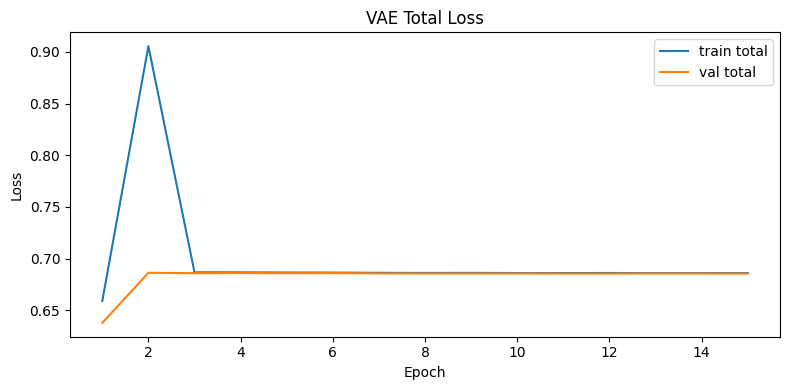

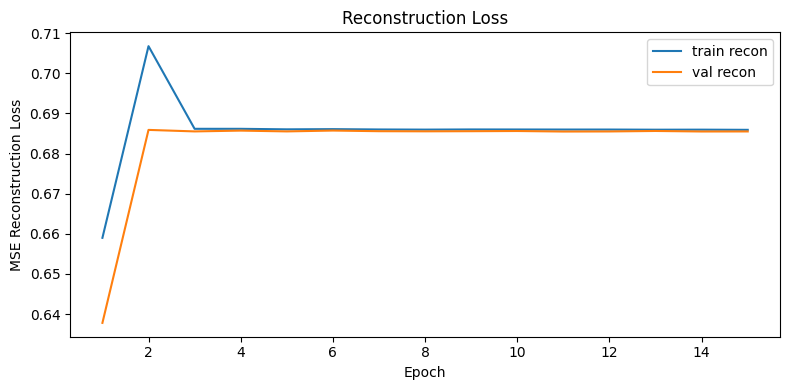

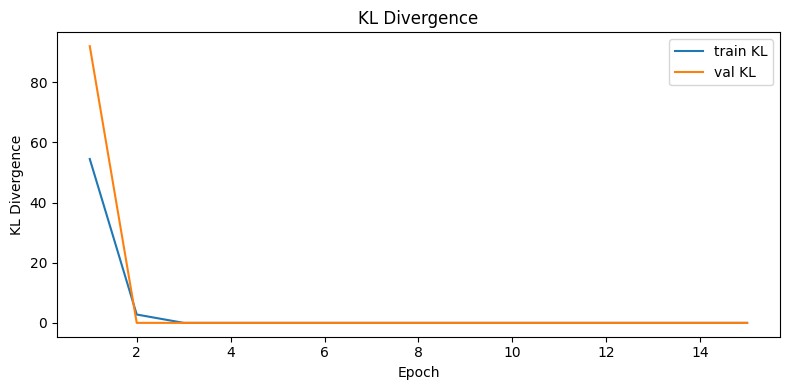

In [118]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, history["train_total"], label="train total")
plt.plot(epochs, history["val_total"],   label="val total")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Total Loss")
plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, history["train_recon"], label="train recon")
plt.plot(epochs, history["val_recon"],   label="val recon")
plt.xlabel("Epoch")
plt.ylabel("MSE Reconstruction Loss")
plt.title("Reconstruction Loss")
plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, history["train_kl"], label="train KL")
plt.plot(epochs, history["val_kl"],   label="val KL")
plt.xlabel("Epoch")
plt.ylabel("KL Divergence")
plt.title("KL Divergence")
plt.legend(); plt.tight_layout()
plt.show()


**How to Read These Curves**

- When reconstruction loss decreases, the decoder is learning to produce outputs closer to inputs — better reconstructions.
- When KL divergence stabilizes at a reasonable scale, the encoder is learning a latent distribution that is well-regularized and smooth, which we can sample from to generate new faces.
- When total loss decreases and validation trends follow training, we are moving toward a useful generative model.

>In the next section, we will visualize reconstructions from the VAE and compare them to those from the plain autoencoder to see the effect of probabilistic latent encoding.

---

### **7. Visualizing Reconstructions**

We now evaluate how well our **VAE** reconstructs faces and compare those outputs to a **plain Autoencoder (AE)**.  
This helps us see the practical effect of a **probabilistic latent space**: VAE reconstructions often look **slightly softer** than AE outputs, reflecting the trade-off between **sharpness** and **latent smoothness**.

> The VAE encourages a continuous, sampleable latent manifold. In practice, this can blur fine details a bit, but it **improves generative consistency**.

**VAE: Original vs. Reconstructed Pairs**

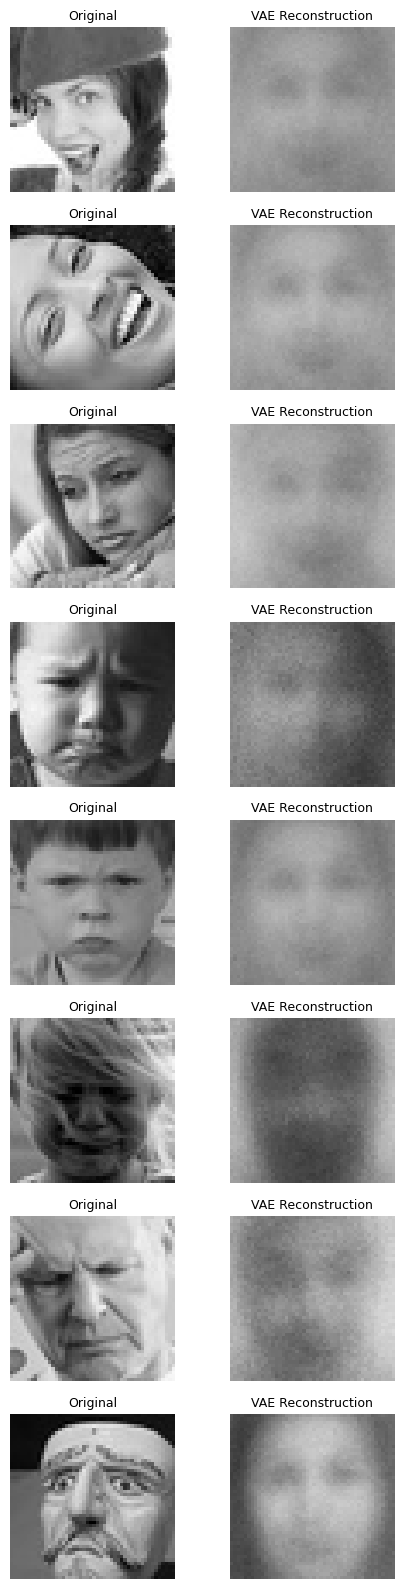

In [119]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Reuse validation data from Section 6; add a light fallback if needed ---
try:
    X_val_t
except NameError:
    import numpy as np
    from sklearn.model_selection import train_test_split
    data = np.load("fer2013_small.npz")
    X, y = data["X"], data["y"]
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )
    X_val_t = torch.tensor(X_val, dtype=torch.float32).view(X_val.shape[0], -1)

device = next(model.parameters()).device  # VAE from Section 4–6
model.eval()

# Select a small batch
idx = torch.randperm(X_val_t.size(0))[:8]
xb = X_val_t[idx].to(device)                      # (N, 2304)
with torch.no_grad():
    x_recon, mu, logvar = model(xb)               # (N, 2304)
xb_img     = xb.view(-1, 48, 48).cpu().numpy()
xrecon_img = x_recon.view(-1, 48, 48).cpu().numpy()

# Plot original vs reconstructed (VAE)
n = xb_img.shape[0]
rows = n
fig, axes = plt.subplots(rows, 2, figsize=(5, 2*rows))
for i in range(rows):
    axes[i, 0].imshow(xb_img[i], cmap="gray", vmin=0.0, vmax=1.0)
    axes[i, 0].set_title("Original", fontsize=9); axes[i, 0].axis("off")

    axes[i, 1].imshow(xrecon_img[i], cmap="gray", vmin=0.0, vmax=1.0)
    axes[i, 1].set_title("VAE Reconstruction", fontsize=9); axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


**Side-by-Side Comparison: AE vs. VAE**

If we also have a trained AE (from NB01) available as ae_model (taking flattened inputs in 
0,1 and returning flattened outputs), we can compare both models on the same images.

In [120]:
import torch
import torch.nn as nn

# For reproducibility
torch.manual_seed(42)

# Flattened input size for 48×48 grayscale images
INPUT_DIM = 48 * 48         # 2304
LATENT_DIM = 128

class FC_Autoencoder(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, latent_dim=LATENT_DIM):
        super().__init__()
        # Encoder: 2304 -> 512 -> 128
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, latent_dim),
            nn.ReLU(inplace=True),
        )
        # Decoder: 128 -> 512 -> 2304
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # constrain output to [0, 1]
        )

    def forward(self, x):
        """
        x: (N, 1, 48, 48) or (N, 48, 48)
        returns: reconstruction with same shape as input
        """
        # Ensure shape is (N, 48, 48)
        if x.dim() == 4:        # (N, 1, 48, 48)
            x = x.squeeze(1)
        # Flatten to (N, 2304)
        n = x.size(0)
        x_flat = x.view(n, -1)
        # Encode -> Decode
        z = self.encoder(x_flat)
        x_hat_flat = self.decoder(z)
        # Reshape back to (N, 48, 48)
        x_hat = x_hat_flat.view(n, 48, 48)
        # Add channel dim back to be consistent with PyTorch image conventions
        x_hat = x_hat.unsqueeze(1)  # (N, 1, 48, 48)
        return x_hat
    
ae_model = FC_Autoencoder().to(device)
ae_model.load_state_dict(torch.load("ae_model.pth", map_location=device))
ae_model.eval()


C:\Users\noman\AppData\Local\Temp\ipykernel_7172\2544325189.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_model.load_state_dict(torch.load("ae_model.pth", map_loca

FC_Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=2304, bias=True)
    (3): Sigmoid()
  )
)

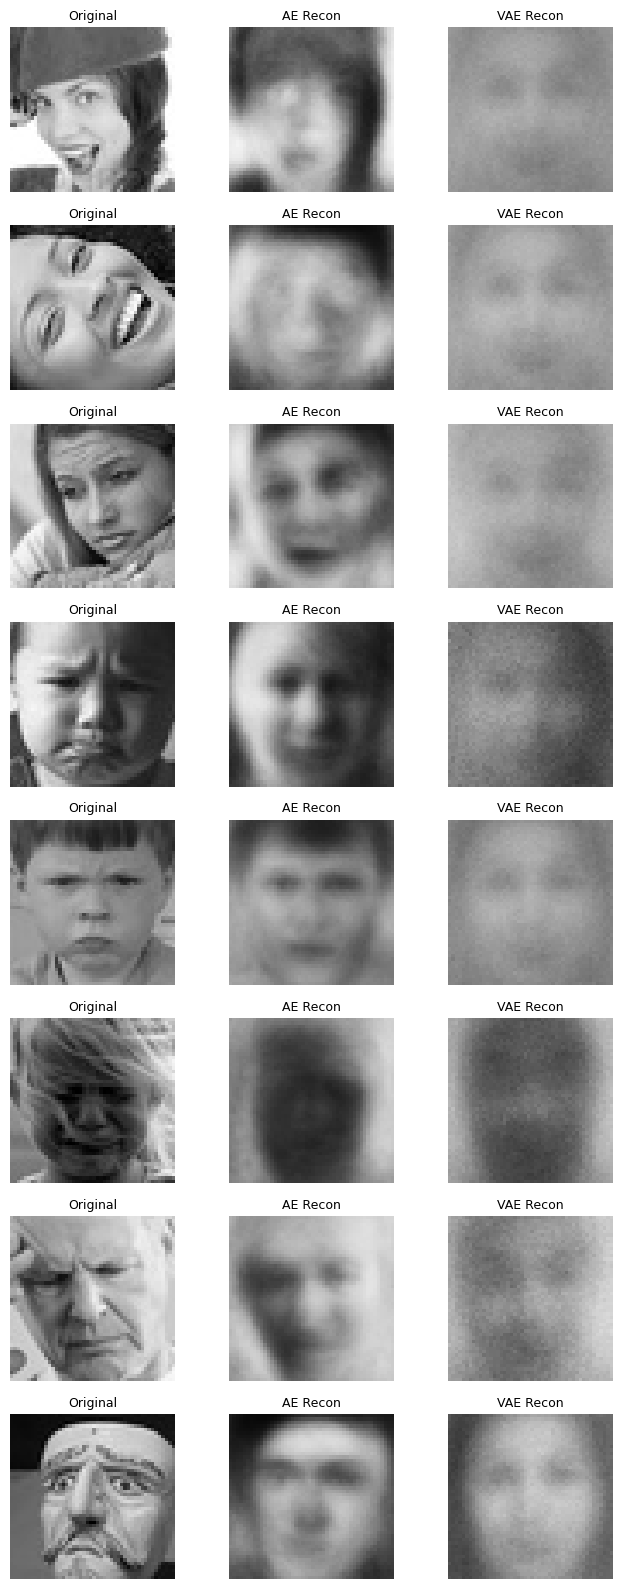

In [121]:
# Optional AE comparison.
# Requirements:
# - ae_model: a trained AE on the same data distribution (flattened 2304 inputs -> 2304 outputs with Sigmoid)
# - If not available, this cell will skip gracefully.

try:
    _ = ae_model
    ae_model = ae_model.to(device).eval()

    with torch.no_grad():
        ae_recon = ae_model(xb)  # (N, 2304)

    ae_img = ae_recon.view(-1, 48, 48).detach().cpu().numpy()

    # Grid: Original | AE Recon | VAE Recon
    n = xb_img.shape[0]
    fig, axes = plt.subplots(n, 3, figsize=(7, 2*n))
    for i in range(n):
        axes[i, 0].imshow(xb_img[i], cmap="gray", vmin=0.0, vmax=1.0)
        axes[i, 0].set_title("Original", fontsize=9); axes[i, 0].axis("off")

        axes[i, 1].imshow(ae_img[i], cmap="gray", vmin=0.0, vmax=1.0)
        axes[i, 1].set_title("AE Recon", fontsize=9); axes[i, 1].axis("off")

        axes[i, 2].imshow(xrecon_img[i], cmap="gray", vmin=0.0, vmax=1.0)
        axes[i, 2].set_title("VAE Recon", fontsize=9); axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

except NameError:
    print("AE model `ae_model` not found. Skipping AE vs VAE comparison. "
          "Provide a trained AE (flattened 2304 → 2304 with Sigmoid) as `ae_model` to enable this plot.")


**How to Interpret What We See**

- VAE Reconstructions:

Often softer than AE outputs. This is expected because the VAE’s latent space is regularized toward a simple prior, trading a bit of pixel-level sharpness for smooth, continuous representations.

- AE vs. VAE:

    - AE focuses strictly on minimizing reconstruction error → sometimes sharper details.

    - VAE balances reconstruction with KL regularization, shaping a sampleable latent space that supports generation and smooth interpolation.

> In the next section, we will sample random latent vectors from the VAE and generate new synthetic faces, showcasing the generative capability we gained by moving from AE to VAE.

---

### **8. Generating Synthetic Faces**

We now demonstrate the **generative power** of our VAE.  
Unlike a plain autoencoder that only reconstructs given inputs, a VAE learns a **probabilistic latent space**. By **sampling** latent vectors
$$
z \sim \mathcal{N}(0, I),
$$
and decoding them, we can generate **new faces** that resemble the training distribution without copying any single image.

> Each random draw of $ z $ corresponds to a *new* point in the learned manifold of faces — evidence that the model has **generalized the structure** of faces rather than memorized examples.

**Sample from $ \mathcal{N}(0, I) $ and Decode**

In [135]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# We assume `model` is our trained VAE from Sections 4–6
device = next(model.parameters()).device
model.eval()
# set seed
torch.manual_seed(42)

# How many samples to generate (must be a square number for a tidy grid)
NUM = 16          # try 16 or 25
LATENT_DIM = model.fc_mu.out_features  # infer latent size from the encoder head

# Sample z ~ N(0, I)
with torch.no_grad():
    z = torch.randn(NUM, LATENT_DIM, device=device)
    x_gen = model.decode(z)                     # (NUM, 2304) if our VAE outputs flat vectors
    x_gen = x_gen.view(NUM, 48, 48).cpu().numpy()


**Visualize as a Grid of Synthetic Faces**

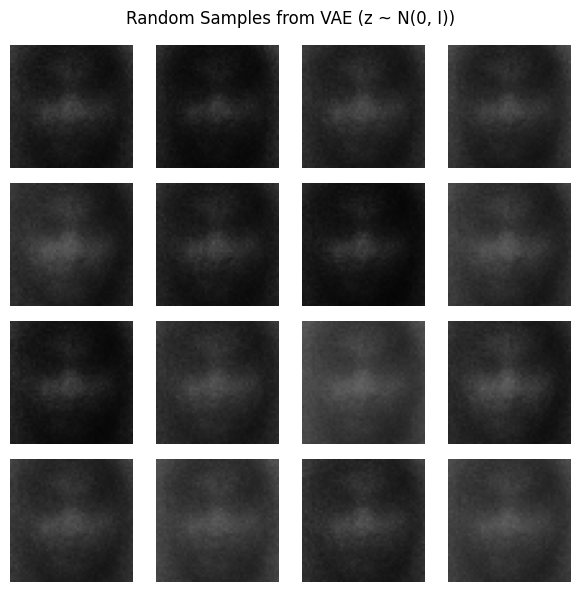

In [136]:
# Display synthetic faces in an n x n grid
n = int(np.sqrt(NUM))
fig, axes = plt.subplots(n, n, figsize=(6, 6))
k = 0
for i in range(n):
    for j in range(n):
        axes[i, j].imshow(x_gen[k], cmap="gray", vmin=0.0, vmax=1.0)
        axes[i, j].axis("off")
        k += 1
plt.suptitle("Random Samples from VAE (z ~ N(0, I))", fontsize=12)
plt.tight_layout()
plt.show()

**8.3 Optional: Temperature (Variance) Scaling for Diversity**

We can control sample diversity by scaling the standard normal noise before decoding:

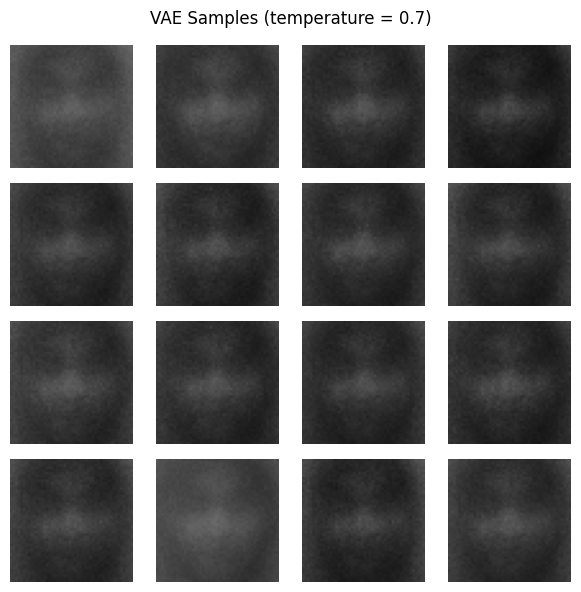

In [137]:
# 'temperature' > 1.0 increases diversity; < 1.0 makes samples more conservative
temperature = 0.7   # try 0.7, 1.0, 1.5
with torch.no_grad():
    z = torch.randn(NUM, LATENT_DIM, device=device) * temperature
    x_gen_t = model.decode(z).view(NUM, 48, 48).cpu().numpy()

fig, axes = plt.subplots(n, n, figsize=(6, 6))
k = 0
for i in range(n):
    for j in range(n):
        axes[i, j].imshow(x_gen_t[k], cmap="gray", vmin=0.0, vmax=1.0)
        axes[i, j].axis("off")
        k += 1
plt.suptitle(f"VAE Samples (temperature = {temperature})", fontsize=12)
plt.tight_layout()
plt.show()

**8.4 What to Look For**

- Plausible facial structure: eyes, nose bridge, mouth contour, and overall head shape should appear coherent.
- Diversity vs. sharpness trade-off: higher temperature yields more variety but may blur details; lower temperature yields safer, more typical faces.
- No exact duplicates: outputs should be new faces drawn from the model’s learned distribution, not copies of training images.

> This step confirms that our VAE has learned a sampleable latent space — a critical milestone on our path from reconstruction to generation.

---

### **9. Exploring the Latent Space**

A key advantage of our VAE is the **structured latent space** it learns.  
By visualizing this space, we can see whether faces with similar expressions or geometry lie close together.  
We will project the encoder’s **mean vectors (μ)** to 2D using **PCA** or **t-SNE** and color points by emotion labels.

> The goal is to connect back to our representation-learning intuition from NB01–NB02: similar inputs should occupy nearby regions in latent space.

**Encode the Validation Set to Get μ Vectors**

In [140]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# -- Ensure we have X_val, y_val, and a trained VAE 'model'
try:
    X_val, y_val
except NameError:
    data = np.load("fer2013_small.npz")
    X, y = data["X"], data["y"]
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

# -- Prepare data loader (flatten images for VAE)
X_val_t = torch.tensor(X_val, dtype=torch.float32).view(X_val.shape[0], -1)
val_ds = TensorDataset(X_val_t, torch.tensor(y_val))
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

device = next(model.parameters()).device
model.eval()

# -- Collect μ (latent means) for all validation images
mus = []
labs = []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        mu, logvar = model.encode(xb)
        mus.append(mu.cpu().numpy())
        labs.append(yb.numpy())

Z_mu = np.concatenate(mus, axis=0)         # shape (N, latent_dim)
y_val_np = np.concatenate(labs, axis=0)

print("Encoded μ shape:", Z_mu.shape, "labels:", y_val_np.shape)

Encoded μ shape: (1239, 32) labels: (1239,)


**2D Projection (PCA or t-SNE)**

- PCA is fast and gives a linear projection.
- t-SNE can reveal non-linear structure but is slower; we often apply PCA to 30 dims first, then t-SNE.

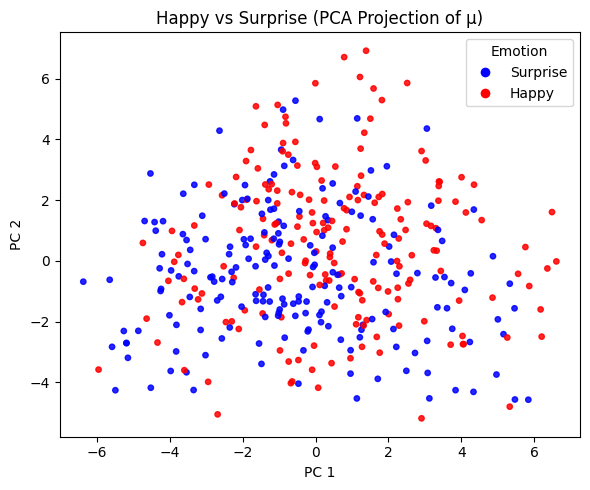

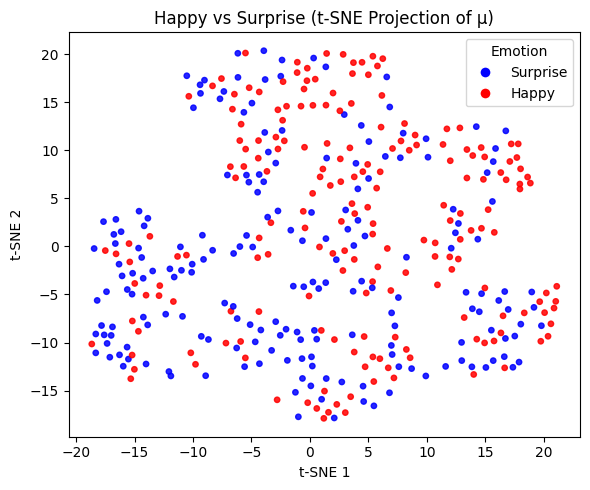

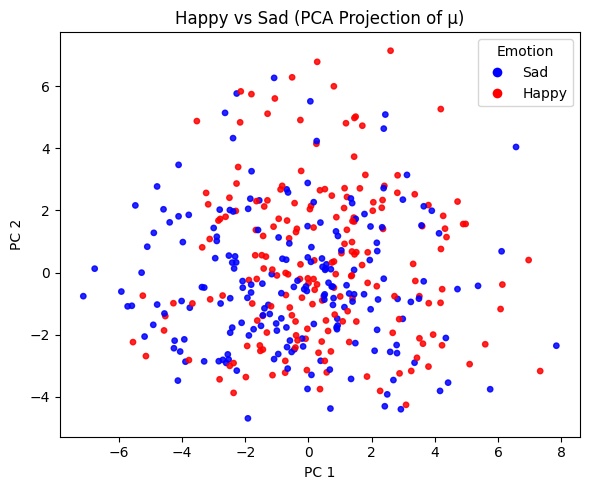

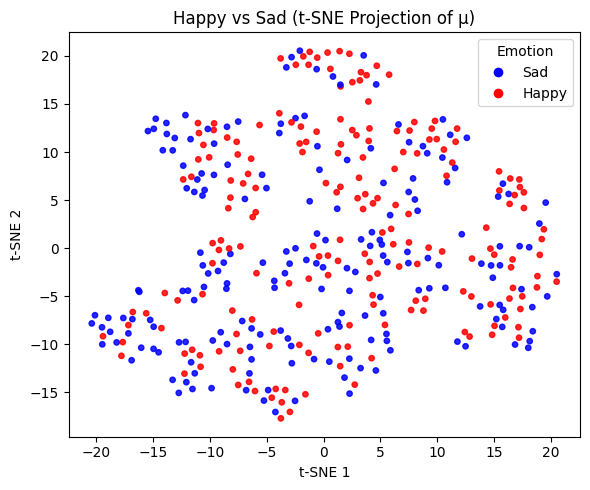

In [ ]:
# -- Emotion names
emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# -- Pairs to visualize
pairs = [
    (3, 5, "Happy vs Surprise"),
    (3, 4, "Happy vs Sad"),
]

for a, b, title in pairs:
    # Filter only the two chosen emotions
    mask = np.isin(y_val_np, [a, b])
    Z_pair = Z_mu[mask]
    y_pair = y_val_np[mask]

    # Re-label to binary (0,1) for consistent color
    y_binary = (y_pair == a).astype(int)  # 1 = Happy, 0 = other

    # Standardize is optional (useful for t-SNE stability)
    # --- PCA (2D) ---
    Z_pca = PCA(n_components=2, random_state=42).fit_transform(Z_pair)

    plt.figure(figsize=(6,5))
    plt.scatter(Z_pca[:,0], Z_pca[:,1], c=y_binary, cmap="bwr", s=15, alpha=0.85)

    # Custom legend
    handles = [
        plt.Line2D([], [], marker="o", color="w", markerfacecolor="blue", markersize=8,
                   label=emotions[b]),
        plt.Line2D([], [], marker="o", color="w", markerfacecolor="red", markersize=8,
                   label=emotions[a]),
    ]
    plt.legend(handles=handles, title="Emotion", loc="best")
    plt.title(f"{title} (PCA Projection of μ)")
    plt.xlabel("PC 1"); plt.ylabel("PC 2")
    plt.tight_layout()
    plt.show()

    # --- t-SNE (optional) ---
    # First reduce to (at most) 30D for speed
    Z_30 = PCA(n_components=min(30, Z_pair.shape[1]), random_state=42).fit_transform(Z_pair)
    Z_tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto",
                  init="pca", random_state=42).fit_transform(Z_30)

    plt.figure(figsize=(6,5))
    plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=y_binary, cmap="bwr", s=15, alpha=0.85)

    # Same legend
    plt.legend(handles=handles, title="Emotion", loc="best")
    plt.title(f"{title} (t-SNE Projection of μ)")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.show()

**How to Read This Plot**

- If points with the same emotion tend to cluster, our encoder is capturing shared expression cues and facial geometry.
- PCA may show broad separation (e.g., strong smiles vs. neutral), while t-SNE can reveal finer groupings.
- Overlap is normal: emotions share features (eyes, head pose, lighting). What matters is that the space is smooth and semantically organized.

> This connects directly to our earlier theme: good latent spaces make downstream tasks easier — from visualization and clustering to controlled generation and interpolation.

---

### **10. Reflection & Key Takeaways**

Let’s pause to reflect on what we’ve achieved with the **Variational Autoencoder (VAE)** and how it differs from the standard Autoencoder (AE).

**Core Insights**
- **Autoencoders (AEs)** focus on *reconstruction* — compressing and decompressing data deterministically.
- **Variational Autoencoders (VAEs)** go further — they *learn a distribution* of latent representations, enabling *generation* of entirely new, unseen examples.
- The **reparameterization trick** bridges random sampling and gradient-based optimization, allowing us to train probabilistic models end-to-end.
- The **KL divergence term** encourages a well-structured latent space that is continuous, smooth, and suitable for interpolation and synthesis.
- The **reconstruction loss** ensures that generated outputs remain faithful to real images.

**Why It Matters**
A VAE doesn’t just memorize — it *understands* the underlying structure of the data.  
This makes VAEs powerful tools for:
- Representation learning  
- Controlled generation (e.g., faces with varying expressions)  
- Semi-supervised learning and anomaly detection  

We’ve moved from *compression* (AE) to *generation* (VAE).

**Forward Connection**
In the next part of our journey, we will explore **Generative Adversarial Networks (GANs)** — a different generative approach where:
- A **Generator** produces synthetic images.
- A **Discriminator** tries to tell real from fake.  
These two networks compete, leading to highly realistic outputs — often sharper and more detailed than VAEs.

> **Think of VAEs as structured, probabilistic artists — and GANs as competitive, creative artists.**

---

### **11. Optional Extensions**

Now that we understand the VAE fundamentals, we can explore several meaningful extensions and experiments.

**(a) Convolutional VAE (CVAE)**
- Replace dense layers with **Conv2d / ConvTranspose2d** layers.
- Captures **spatial hierarchies** in images → sharper, more coherent reconstructions.
- Ideal for face or object image datasets.

**(b) Latent Dimensionality Experiments**
- Try smaller (e.g., 8) or larger (e.g., 32, 64) latent vector sizes.  
- Observe trade-offs between:
  - Reconstruction sharpness  
  - Latent smoothness and diversity  

**(c) Latent Traversal Visualization**
- Vary one dimension of the latent vector \( z \) while keeping others fixed.
- Decode and visualize outputs → observe gradual transformation in expressions or features (smile intensity, head tilt, etc.).
- This helps us interpret what each latent variable represents.

**(d) β-VAE Experiment**
- Modify total loss:  
  $$
  L = L_\text{recon} + \beta \, L_\text{KL}
  $$
- Increasing **β > 1** enforces stronger disentanglement between latent factors, at the cost of reconstruction quality.
- Helps us explore **information bottleneck** and **disentangled representation learning**.

> **In summary:**  
> VAEs introduced us to *probabilistic deep learning* — a bridge between classical variational inference and modern neural architectures.  
> From here, we move toward *adversarial learning* (GANs), *conditional generation*, and *disentanglement* — key ideas shaping today’s generative AI landscape.
